# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

**DOUBTS**
- Calcolare alpha e beta per ogni stazione con il fit di scipy? Vanno messe due nuove colonne nel dataset? Se c'è una sola osservazione non posso fare il fit => uniforme? (alpha=1, beta=1)
- Output: AMS o alpha e beta?
- Initial guess? 
- Alpha e beta predetti per ogni stazione come vanno paragonati con quelli "veri"? Intervallo di confidenza sulla media o sui parametri (questo come si calcola) ?
- Come si fa inferenza su più distribuzioni? Quali metriche?
- 20 epoche e 2 hidden impara come 2 epoche e 0 hidden

**TO DO**
- provare con solo MAP in input
- pca?
- nel test ogni stazione ha senso che ci sia una sola volta, tanto l'output sarà sempre lo stesso


# 0. Importing libraries

In [1]:
colab = False

if colab:
    !pip install fitter
    !pip install pydot
    !pip install graphviz
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

from scipy import stats


C:\Users\shola\AppData\Local\Temp\ipykernel_380\1357901882.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [90]:
from importlib import reload  
from utils import util
util = reload(util)

# 1. Load and inspect the dataset

## 1.1. Load data

In [3]:
df, df_indexes_test = util.load_data(colab)
print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [4]:
df

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274542,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.918877,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274543,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.950230,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274544,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.602938,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513
274545,21338,'Vicenza_-_Sant_Agostino',33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,...,696822.00,5044294.00,24,0.877878,82.927273,0.903636,0.193259,1.792657,1.477653,1.193513


In [5]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', 'loc', 'scale', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


In [6]:
#drop duplicate rows

df = df.drop_duplicates()
df = df.reset_index(drop=True)
df

,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h],AMS,mean_IdD
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1,1.221239,28.250000
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.338470,633069.81,4890553.68,1,0.778761,28.250000
2,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,1.219018,33.469565
3,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,0.979995,33.469565
4,5002,531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,384.928238,...,1211.976807,1519.375977,12.727350,370.017700,23.933985,555576.92,4921743.21,1,1.153287,33.469565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253780,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,24,0.918877,82.927273
253781,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,24,0.950230,82.927273
253782,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,24,0.602938,82.927273
253783,21338,33.290198,3.489680,0.844974,1.510106,172.196092,94.760327,66.170105,15.368078,16.490707,...,1741.666260,1088.090942,4.371147,249.977951,10.285090,696822.00,5044294.00,24,0.877878,82.927273


## 1.2. Preprocess and split the dataset

### Split the dataset into train, validation and test

In [7]:
# Take the first 100 ID and use them to create the test sets
test_ID = df_indexes_test['ID'].to_list()[:100]
test_df = df[df['ID'].isin(test_ID)]
test_df.reset_index(drop=True, inplace=True)

# Drop the test set from df and then create the train sets and validation sets
df = df.drop(df[df['ID'].isin(test_ID)].index)
df.reset_index(drop=True, inplace=True)

validation_split = 0.1
df = df.sort_values(by=['ID'])
    
train_df, val_df = train_test_split(df, test_size=validation_split, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [8]:
train_df.head()

,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h],AMS,mean_IdD
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,1,1.221239,28.25
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,12,1.041667,144.00
2,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,12,0.729167,144.00
3,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,6,0.811594,86.25
4,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,1923.808472,1948.225952,577.581116,484.327515,281.33847,633069.81,4890553.68,6,1.113043,86.25


### Standardize datasets

In [9]:
train_df_std = util.standardize(train_df, 'beta')
val_df_std = util.standardize(val_df, 'beta')
test_df_std = util.standardize(test_df, 'beta')

In [10]:
# column id must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

# column duration must be integer
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

In [11]:
train_df_std.head()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,0.192017,28.25,1,1.490199,0.248545,0.100663,-0.432418,2.349501,0.207258,...,-0.783061,1.037688,1.03101,0.63593,2.153039,4.595839,1.757382,4.549447,0.529131,-0.715929
1,5001,0.163739,144.00,12,1.490199,0.248545,0.100663,-0.432418,2.349501,0.207258,...,-0.783061,1.037688,1.03101,0.63593,2.153039,4.595839,1.757382,4.549447,0.529131,-0.715929
2,5001,0.114529,144.00,12,1.490199,0.248545,0.100663,-0.432418,2.349501,0.207258,...,-0.783061,1.037688,1.03101,0.63593,2.153039,4.595839,1.757382,4.549447,0.529131,-0.715929
3,5001,0.127509,86.25,6,1.490199,0.248545,0.100663,-0.432418,2.349501,0.207258,...,-0.783061,1.037688,1.03101,0.63593,2.153039,4.595839,1.757382,4.549447,0.529131,-0.715929
4,5001,0.174979,86.25,6,1.490199,0.248545,0.100663,-0.432418,2.349501,0.207258,...,-0.783061,1.037688,1.03101,0.63593,2.153039,4.595839,1.757382,4.549447,0.529131,-0.715929


In [12]:
train_df_std.describe()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
count,215817.000000,215817.000000,215817.000000,215817.000000,2.158170e+05,2.158170e+05,2.158170e+05,2.158170e+05,2.158170e+05,2.158170e+05,...,2.158170e+05,2.158170e+05,2.158170e+05,2.158170e+05,2.158170e+05,2.158170e+05,2.158170e+05,2.158170e+05,2.158170e+05,2.158170e+05
mean,11043.082394,0.158408,58.043180,9.404755,1.380149e-16,2.107097e-17,9.060517e-17,5.478452e-17,-6.553072e-16,-8.196607e-16,...,2.949936e-17,4.846323e-17,-8.428388e-18,2.823510e-16,-3.413497e-16,8.059646e-17,-8.428388e-18,-3.845452e-17,-9.692646e-17,-7.644548e-15
std,4304.574689,0.060452,31.359107,8.327367,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,5001.000000,0.001000,5.200000,1.000000,-1.061999e+00,-1.230601e+00,-1.401062e+00,-1.591473e+00,-4.350035e+00,-3.504949e+00,...,-1.380174e+00,-1.467158e+00,-1.676236e+00,-1.831949e+00,-1.619539e+00,-4.791761e-01,-1.583168e+00,-6.299797e-01,-1.971316e+00,-1.790725e+00
25%,8097.000000,0.117288,35.550000,3.000000,-7.431754e-01,-8.624041e-01,-9.494492e-01,-7.309249e-01,-5.887503e-01,-6.327020e-01,...,-9.070151e-01,-5.836724e-01,-7.765338e-01,-7.169206e-01,-7.893510e-01,-4.527778e-01,-8.136283e-01,-5.110371e-01,-9.109792e-01,-7.791347e-01
50%,12008.000000,0.147431,50.651905,6.000000,-2.939002e-01,-1.287834e-01,2.805431e-02,7.210927e-02,1.856210e-03,5.154744e-02,...,-4.848551e-02,-1.400653e-01,-1.556733e-01,-1.716997e-01,-2.330770e-01,-4.211600e-01,-2.299178e-01,-4.340795e-01,1.260139e-01,-2.891105e-01
75%,16057.000000,0.186643,71.553846,12.000000,4.620137e-01,6.275794e-01,7.058093e-01,6.822129e-01,6.255724e-01,6.813046e-01,...,6.883029e-01,3.632835e-01,6.408377e-01,5.234956e-01,5.757468e-01,-2.271675e-01,6.282470e-01,-1.015363e-01,7.836133e-01,7.800225e-01
max,20035.000000,0.990000,318.742857,24.000000,5.301189e+00,3.745246e+00,2.930799e+00,3.569575e+00,3.606547e+00,2.897082e+00,...,2.573030e+00,5.243465e+00,3.685897e+00,3.302488e+00,4.292674e+00,7.242871e+00,3.486248e+00,6.056845e+00,2.168752e+00,2.524393e+00


### Add the guesses to datasets

In [13]:
def add_alpha_beta(df):
 
    # create two empy columns for alpha and beta
    df['alpha'] = np.nan
    df['beta'] = np.nan
 
    for id in df['ID'].unique():
       
        for duration in DURATION:
            condition = (df['ID'] == id) & (df['duration[h]'] == duration)
            ams = df[condition]['AMS']
           
            
            if len(ams) < 7:
                a, b = np.nan, np.nan
            else:
                a, b, _, _ = stats.beta.fit(ams, floc=0, fscale=1)
                
                        
            df.loc[condition, 'alpha'] = a
            df.loc[condition, 'beta'] = b
 
    # if there are nan values
    #if df.isnull().values.any():
        #raise Exception('There are nan values in the dataframe')
    df.dropna(inplace=True)
 
    return df

In [14]:
train_df_std = add_alpha_beta(train_df_std)
val_df_std = add_alpha_beta(val_df_std)
test_df_std = add_alpha_beta(test_df_std)

In [15]:
train_df_std

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,alpha,beta
18,5002,0.296074,68.330435,6,-0.031322,-0.536868,-0.557926,-0.552699,1.324287,1.460218,...,-0.342417,-0.279062,1.014088,-0.367345,0.690888,-0.189356,-0.085540,-0.376840,3.585096,19.013652
19,5002,0.167017,68.330435,6,-0.031322,-0.536868,-0.557926,-0.552699,1.324287,1.460218,...,-0.342417,-0.279062,1.014088,-0.367345,0.690888,-0.189356,-0.085540,-0.376840,3.585096,19.013652
20,5002,0.335713,68.330435,6,-0.031322,-0.536868,-0.557926,-0.552699,1.324287,1.460218,...,-0.342417,-0.279062,1.014088,-0.367345,0.690888,-0.189356,-0.085540,-0.376840,3.585096,19.013652
21,5002,0.090966,68.330435,6,-0.031322,-0.536868,-0.557926,-0.552699,1.324287,1.460218,...,-0.342417,-0.279062,1.014088,-0.367345,0.690888,-0.189356,-0.085540,-0.376840,3.585096,19.013652
22,5002,0.430661,68.330435,6,-0.031322,-0.536868,-0.557926,-0.552699,1.324287,1.460218,...,-0.342417,-0.279062,1.014088,-0.367345,0.690888,-0.189356,-0.085540,-0.376840,3.585096,19.013652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215812,20035,0.147132,32.471429,1,1.208150,2.814207,1.703807,0.744632,3.051661,-1.072528,...,0.520718,1.156827,0.326343,0.908536,0.894914,1.332808,-1.233112,1.054352,14.532028,76.031452
215813,20035,0.150042,32.471429,1,1.208150,2.814207,1.703807,0.744632,3.051661,-1.072528,...,0.520718,1.156827,0.326343,0.908536,0.894914,1.332808,-1.233112,1.054352,14.532028,76.031452
215814,20035,0.126764,32.471429,1,1.208150,2.814207,1.703807,0.744632,3.051661,-1.072528,...,0.520718,1.156827,0.326343,0.908536,0.894914,1.332808,-1.233112,1.054352,14.532028,76.031452
215815,20035,0.274191,32.471429,1,1.208150,2.814207,1.703807,0.744632,3.051661,-1.072528,...,0.520718,1.156827,0.326343,0.908536,0.894914,1.332808,-1.233112,1.054352,14.532028,76.031452


In [16]:
train_df_std.describe()

,ID,AMS,mean_IdD,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),...,OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,alpha,beta
count,209219.000000,209219.000000,209219.000000,209219.000000,209219.000000,209219.000000,209219.000000,209219.000000,209219.000000,209219.000000,...,209219.000000,209219.000000,209219.000000,209219.000000,209219.000000,209219.000000,209219.000000,209219.000000,209219.000000,209219.000000
mean,11054.984065,0.158443,58.129032,9.412802,-0.000540,-0.000708,-0.000054,0.000342,0.000532,0.000885,...,-0.001810,-0.002305,-0.000964,-0.000895,0.000802,-0.000352,-0.004631,-0.007906,7.846916,41.681713
std,4312.113089,0.060717,31.348658,8.329357,0.997349,0.998518,0.998811,0.999317,0.996468,1.000399,...,1.001378,0.999900,1.002480,0.997123,1.003102,0.999495,1.003741,0.996461,4.354243,23.433511
min,5002.000000,0.001000,9.613333,1.000000,-1.060103,-1.230601,-1.401062,-1.591473,-4.350035,-3.491168,...,-1.676236,-1.831949,-1.619539,-0.479176,-1.583168,-0.629980,-1.971316,-1.790725,0.670234,3.447993
25%,8095.000000,0.117101,35.572840,3.000000,-0.740906,-0.859879,-0.947123,-0.730587,-0.584526,-0.632702,...,-0.777419,-0.722960,-0.789351,-0.452853,-0.813628,-0.511561,-0.924237,-0.782063,5.280259,27.883207
50%,12018.000000,0.147211,50.748387,6.000000,-0.293900,-0.128783,0.028054,0.072462,0.001856,0.052682,...,-0.163667,-0.171700,-0.238240,-0.421346,-0.230769,-0.434079,0.126014,-0.294308,6.900272,36.563887
75%,16057.000000,0.186748,71.755556,12.000000,0.462743,0.616598,0.704580,0.681885,0.624763,0.682373,...,0.640108,0.522380,0.565777,-0.227167,0.626710,-0.101536,0.783613,0.762388,9.267552,49.323801
max,20035.000000,0.990000,318.742857,24.000000,4.211064,3.745246,2.849382,3.569575,3.606547,2.897082,...,3.685897,3.302488,4.292674,6.028768,3.486248,6.019465,2.168752,2.524393,99.779052,535.026721


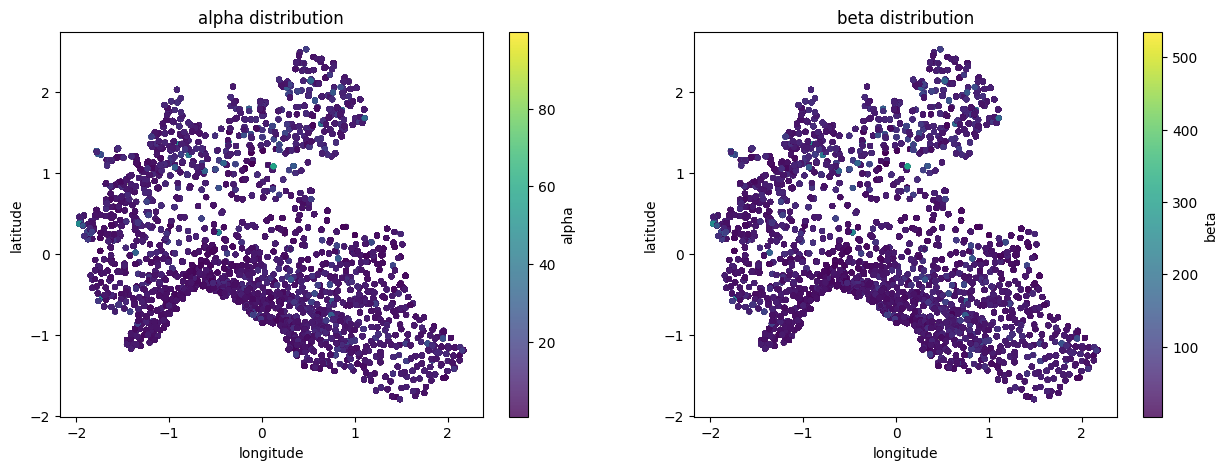

In [17]:
util.geographic_plot(train_df_std, 'alpha', 'beta')

8
[0.16212105 0.15021817 0.1360115  0.14330682 0.17095222 0.15367385
 0.15597763 0.18515889]
99.7790517924759 535.026720955404
0.1571775168595963 0.014576018597782408


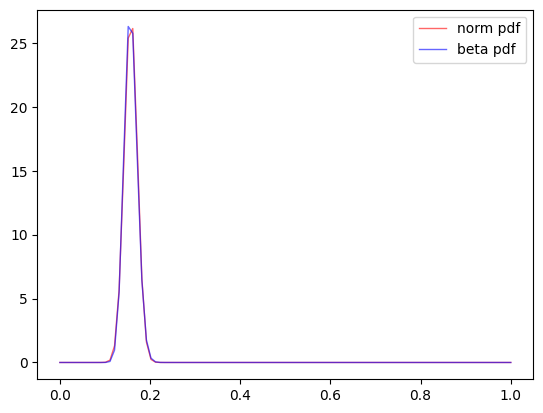

In [18]:
#histogram of AMS when alpha > 90 and beta > 500

condition = (train_df_std['alpha'] > 90) & (train_df_std['beta'] > 500)
ams = train_df_std[condition]['AMS']
print(len(ams))
print(ams.values)
a, b, _, _ = stats.beta.fit(ams, floc=0, fscale=1)
print(a, b)
m, d = stats.norm.fit(ams)
print(m, d)

x = np.linspace(0, 1, 100)
dist_norm = stats.norm.pdf(x, m, d)
dist_beta = stats.beta.pdf(x, a, b)

plt.plot(x, dist_norm, 'r-', lw=1, alpha=0.6, label='norm pdf')
plt.plot(x, dist_beta, 'b-', lw=1, alpha=0.6, label='beta pdf')
plt.legend()
plt.show()

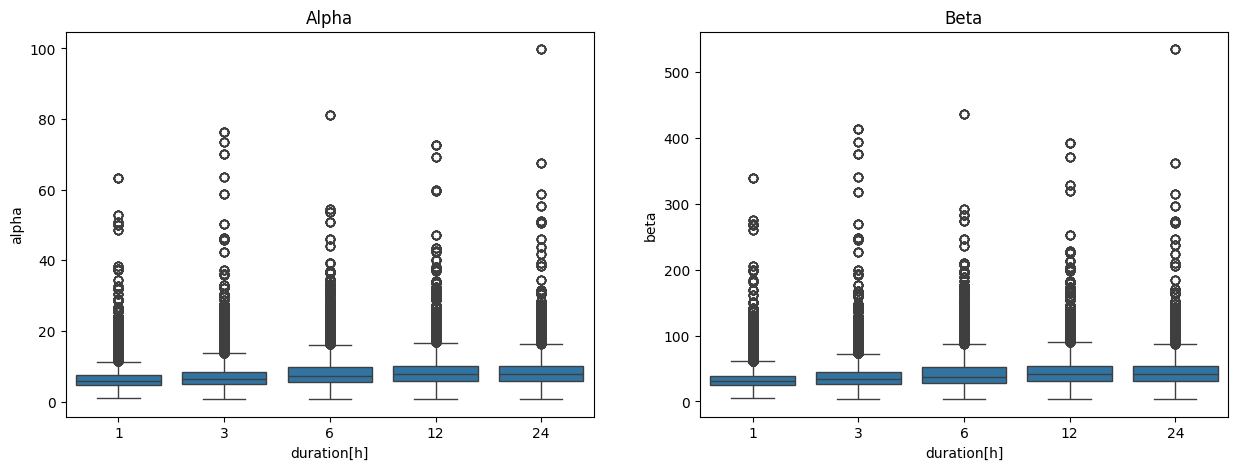

In [19]:
#boxplot of alpha and beta
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='duration[h]', y='alpha', data=train_df_std, ax=ax[0])
ax[0].set_title('Alpha')

sns.boxplot(x='duration[h]', y='beta', data=train_df_std, ax=ax[1])
ax[1].set_title('Beta')

plt.show()

In [20]:
#take the ID with the highest alpha and beta for each duration
def get_highest_alpha_beta(df, duration):
    highest_alpha = df[df['duration[h]']==duration]['alpha'].max()
    highest_beta = df[df['duration[h]']==duration]['beta'].max()
    return highest_alpha, highest_beta

for duration in DURATION:
    highest_alpha, highest_beta = get_highest_alpha_beta(train_df_std, duration)
    highest_alpha_ID = train_df_std.loc[train_df_std['alpha'] == highest_alpha, 'ID'].values[0] # [0] because the array contains the same value repeated
    highest_beta_ID = train_df_std.loc[train_df_std['beta'] == highest_beta, 'ID'].values[0]
    
    print('Duration: ', duration)
    print('Highest alpha: ', highest_alpha)
    print('Highest alpha ID: ', highest_alpha_ID)
    print('Highest beta: ', highest_beta)
    print('Highest beta ID: ', highest_beta_ID)
    ams = train_df_std[(train_df_std['ID']==highest_beta_ID)&(train_df_std['duration[h]']==duration)]['AMS']
    print('\t AMS:', ams.values)
    print('\n')

Duration:  1
Highest alpha:  63.199555234833205
Highest alpha ID:  16572
Highest beta:  338.8857904649904
Highest beta ID:  16572
	 AMS: [0.12870778 0.14761347 0.14538927 0.16095865 0.16651915 0.18653693
 0.13982877 0.18431273 0.14427717 0.16763125]


Duration:  3
Highest alpha:  76.2946823686722
Highest alpha ID:  9319
Highest beta:  414.3240537280519
Highest beta ID:  9319
	 AMS: [0.17726804 0.15932924 0.13895806 0.13713377 0.18882184 0.16206566
 0.15294424 0.16875471 0.14443091 0.13257306 0.14291067 0.16084948]


Duration:  6
Highest alpha:  81.0574798554992
Highest alpha ID:  9084
Highest beta:  436.4367794743987
Highest beta ID:  9084
	 AMS: [0.16243557 0.17643915 0.1614698  0.13346264 0.13056535 0.17402474
 0.15760675 0.15712386]


Duration:  12
Highest alpha:  72.52636068858816
Highest alpha ID:  5238
Highest beta:  391.9625367925722
Highest beta ID:  5238
	 AMS: [0.12574785 0.15303562 0.18552107 0.13419406 0.13484377 0.16667951
 0.14328999 0.15043679 0.16213155 0.18097311 0.161

In [21]:
AMS_count = train_df_std.groupby(['ID','duration[h]'])['AMS'].count()
AMS_count = pd.DataFrame(AMS_count)
AMS_count.columns = ['count']
AMS_count['alpha'] = train_df_std.groupby(['ID','duration[h]'])['alpha'].mean() #prendo la media tanto lo stesso valore è ripetuto
AMS_count['beta'] = train_df_std.groupby(['ID','duration[h]'])['beta'].mean()

AMS_count.head(15)

count     alpha       beta
ID   duration[h]                            
5002 1               21  6.022498  31.665955
     3               22  3.212007  16.700984
     6               23  3.585096  19.013652
     12              23  4.753417  25.449980
     24              23  4.118149  22.052723
5003 1               44  4.419352  22.743021
     3               46  2.814619  14.924831
     6               45  2.819134  15.206739
     12              47  2.932842  15.656147
     24              49  3.004918  16.200543
5004 1               29  7.995394  42.445376
     3               28  6.534131  34.203401
     6               28  7.149172  37.441969
     12              27  7.620389  39.181767
     24              29  7.643943  40.270280

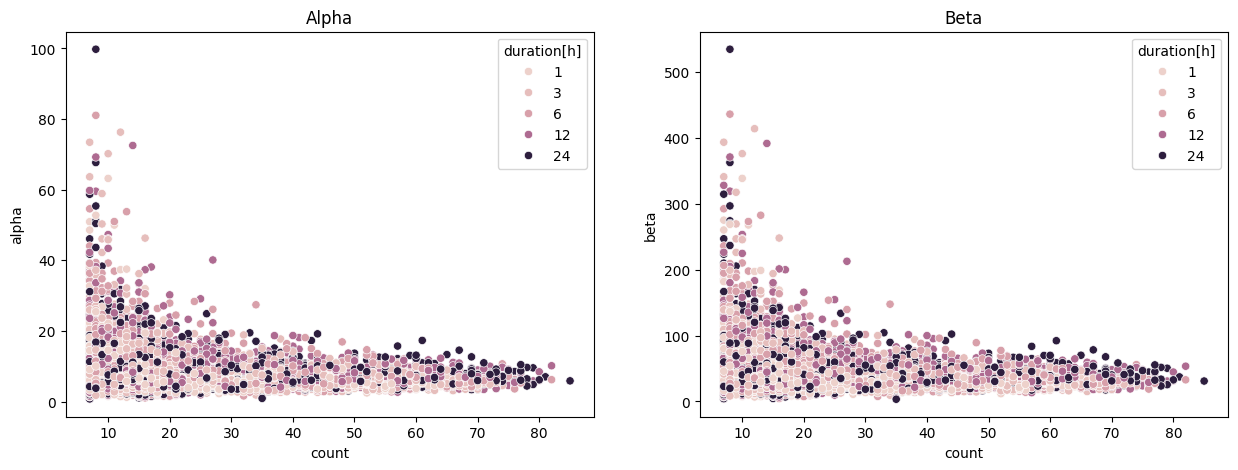

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='count', y='alpha', data=AMS_count, ax=ax[0], hue='duration[h]')
ax[0].set_title('Alpha')

sns.scatterplot(x='count', y='beta', data=AMS_count, ax=ax[1], hue='duration[h]')
ax[1].set_title('Beta')

plt.show()

## 1.4. Prepare data for training

In [23]:
# sort the dataframes by ID and then by duration
train_df_std = train_df_std.sort_values(by=['ID', 'duration[h]'])
val_df_std = val_df_std.sort_values(by=['ID', 'duration[h]'])
test_df_std = test_df_std.sort_values(by=['ID', 'duration[h]'])

# create a dict to store the indexes of same durations
durations_indexes_train = {}
for duration in DURATION:
    durations_indexes_train[duration] = train_df_std[train_df_std['duration[h]'] == duration].index

durations_indexes_val = {}
for duration in DURATION:
    durations_indexes_val[duration] = val_df_std[val_df_std['duration[h]'] == duration].index

durations_indexes_test = {}
for duration in DURATION:
    durations_indexes_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].index

In [24]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'duration[h]', 'HMerit_mean(m)',
       'HMerit_stdev(m)', 'Slope_mean(deg)', 'Slope_stdev(deg)',
       'Aspect_mean(deg)', 'Aspect_stdev(deg)', 'MinDistAdriaticC_(km)',
       'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)', 'OrogrAdri_max(m)',
       'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)', 'OrograTirr_stdev(m)',
       'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)', 'VarClimPT(mm)',
       'VarClimSowP(mm)', 'X', 'Y', 'alpha', 'beta'],
      dtype='object')

In [25]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_df_std.columns
input_columns = train_df_std.columns [3:-2] 
output_column = 'AMS'
parameters_columns = ['ID','duration[h]','alpha', 'beta']
print('Input columns: ', input_columns)

Input columns:  Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [26]:
inputs_train = train_df_std[input_columns]
outputs_train = train_df_std[output_column]
parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns]
outputs_val = val_df_std[output_column]
parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [27]:
#make ohe for duration

inputs_train = pd.get_dummies(inputs_train, columns=['duration[h]'])
inputs_val = pd.get_dummies(inputs_val, columns=['duration[h]'])
inputs_test = pd.get_dummies(inputs_test, columns=['duration[h]'])

for duration in DURATION:
    inputs_train['duration[h]_'+str(duration)] = inputs_train['duration[h]_'+str(duration)].astype(int)
    inputs_val['duration[h]_'+str(duration)] = inputs_val['duration[h]_'+str(duration)].astype(int)
    inputs_test['duration[h]_'+str(duration)] = inputs_test['duration[h]_'+str(duration)].astype(int)

inputs_train

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
41,-0.031322,-0.536868,-0.557926,-0.552699,1.324287,1.460218,-0.014698,-0.026265,0.354371,0.162319,...,-0.367345,0.690888,-0.189356,-0.085540,-0.376840,1,0,0,0,0
42,-0.031322,-0.536868,-0.557926,-0.552699,1.324287,1.460218,-0.014698,-0.026265,0.354371,0.162319,...,-0.367345,0.690888,-0.189356,-0.085540,-0.376840,1,0,0,0,0
43,-0.031322,-0.536868,-0.557926,-0.552699,1.324287,1.460218,-0.014698,-0.026265,0.354371,0.162319,...,-0.367345,0.690888,-0.189356,-0.085540,-0.376840,1,0,0,0,0
45,-0.031322,-0.536868,-0.557926,-0.552699,1.324287,1.460218,-0.014698,-0.026265,0.354371,0.162319,...,-0.367345,0.690888,-0.189356,-0.085540,-0.376840,1,0,0,0,0
46,-0.031322,-0.536868,-0.557926,-0.552699,1.324287,1.460218,-0.014698,-0.026265,0.354371,0.162319,...,-0.367345,0.690888,-0.189356,-0.085540,-0.376840,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215785,1.208150,2.814207,1.703807,0.744632,3.051661,-1.072528,1.254118,-0.588151,-0.008444,1.363526,...,0.908536,0.894914,1.332808,-1.233112,1.054352,0,0,0,1,0
215786,1.208150,2.814207,1.703807,0.744632,3.051661,-1.072528,1.254118,-0.588151,-0.008444,1.363526,...,0.908536,0.894914,1.332808,-1.233112,1.054352,0,0,0,1,0
215787,1.208150,2.814207,1.703807,0.744632,3.051661,-1.072528,1.254118,-0.588151,-0.008444,1.363526,...,0.908536,0.894914,1.332808,-1.233112,1.054352,0,0,0,1,0
215788,1.208150,2.814207,1.703807,0.744632,3.051661,-1.072528,1.254118,-0.588151,-0.008444,1.363526,...,0.908536,0.894914,1.332808,-1.233112,1.054352,0,0,0,1,0


In [28]:
#MAP
inputs_train_map = inputs_train[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_val_map = inputs_val[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_test_map = inputs_test[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]

inputs_train_map

,MAP(mm),duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
41,1.014088,1,0,0,0,0
42,1.014088,1,0,0,0,0
43,1.014088,1,0,0,0,0
45,1.014088,1,0,0,0,0
46,1.014088,1,0,0,0,0
...,...,...,...,...,...,...
215785,0.326343,0,0,0,1,0
215786,0.326343,0,0,0,1,0
215787,0.326343,0,0,0,1,0
215788,0.326343,0,0,0,1,0


In [29]:
#PCA
inputs_train_pca = util.make_pca(inputs_train, 5)
inputs_val_pca = util.make_pca(inputs_val, 5)
inputs_test_pca = util.make_pca(inputs_test, 5)

inputs_train_pca

,0,1,2,3,4
0,-0.660260,-1.033935,-0.17222,0.654236,1.280986
1,-0.660260,-1.033935,-0.17222,0.654236,1.280986
2,-0.660260,-1.033935,-0.17222,0.654236,1.280986
3,-0.660260,-1.033935,-0.17222,0.654236,1.280986
4,-0.660260,-1.033935,-0.17222,0.654236,1.280986
...,...,...,...,...,...
209214,4.043618,-0.672179,0.37191,0.126641,-0.481939
209215,4.043618,-0.672179,0.37191,0.126641,-0.481939
209216,4.043618,-0.672179,0.37191,0.126641,-0.481939
209217,4.043618,-0.672179,0.37191,0.126641,-0.481939


# 2. Model definition

#### Base model

In [30]:
def build_nn_beta_model(input_shape, hidden):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)

    alpha_beta = layers.Dense(2, activation='exponential')(x)

    lf = lambda t: tfp.distributions.Beta(concentration0=t[:,0:1], concentration1=t[:,1:2], validate_args=True, allow_nan_stats=False)
    model_out = tfp.layers.DistributionLambda(lf)(alpha_beta)
    model = keras.Model(model_in, model_out)
    return model

# 4. Training

## Training

In [31]:
y_train  = outputs_train.values
y_val = outputs_val.values
y_test = outputs_test.values

In [32]:
# Parameters for the training
batch_size = 512
epochs = 90 
lr = 1e-3
patience = 30
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

* MAP-model

Training the model with only MAP descriptor...



Epoch 1/90

409/409 [==============================] - 4s 6ms/step - loss: -1.3975 - val_loss: -1.0728
Epoch 2/90
409/409 [==============================] - 2s 5ms/step - loss: -1.4700 - val_loss: -1.0343
Epoch 3/90
409/409 [==============================] - 2s 5ms/step - loss: -1.4713 - val_loss: -0.9559
Epoch 4/90
409/409 [==============================] - 3s 7ms/step - loss: -1.4727 - val_loss: -0.9717
Epoch 5/90
409/409 [==============================] - 2s 5ms/step - loss: -1.4723 - val_loss: -1.0563
Epoch 6/90
409/409 [==============================] - 2s 5ms/step - loss: -1.4716 - val_loss: -1.0696
Epoch 7/90
409/409 [==============================] - 2s 4ms/step - loss: -1.4725 - val_loss: -1.0674
Epoch 8/90
409/409 [==============================] - 2s 5ms/step - loss: -1.4726 - val_loss: -1.0287
Epoch 9/90
409/409 [==============================] - 3s 7ms/step - loss: -1.4734 - val_loss: -0.9925
Epoch 10/90
409/409 [==============================] - 2s 5ms/step - loss: -1.47

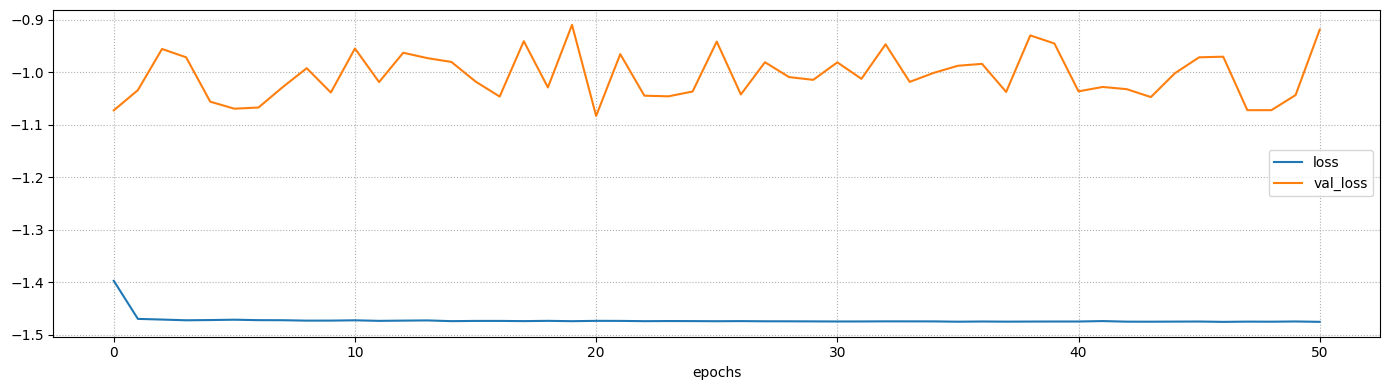

Final loss: -1.4757 (training), -0.9191 (validation)


In [33]:
X_train_map = inputs_train_map.values
X_val_map = inputs_val_map.values
X_test_map = inputs_test_map.values

print('Training the model with only MAP descriptor...')
map_model = build_nn_beta_model(input_shape=(X_train_map.shape[1],), hidden=[128,256]) #[256,128]
history = util.train_nn_model(map_model, X_train_map, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_map, y_val))
util.plot_training_history(history, figsize=(14, 4))


* Full-model

Training the model with all morphoclimatic descriptors...
Epoch 1/90
409/409 [==============================] - 5s 9ms/step - loss: -1.4061 - val_loss: -0.7686
Epoch 2/90
409/409 [==============================] - 2s 5ms/step - loss: -1.4703 - val_loss: -0.8712
Epoch 3/90
409/409 [==============================] - 2s 6ms/step - loss: -1.4763 - val_loss: -0.8483
Epoch 4/90
409/409 [==============================] - 3s 7ms/step - loss: -1.4790 - val_loss: -0.7266
Epoch 5/90
409/409 [==============================] - 3s 7ms/step - loss: -1.4810 - val_loss: -0.8256
Epoch 6/90
409/409 [==============================] - 2s 5ms/step - loss: -1.4825 - val_loss: -0.6547
Epoch 7/90
409/409 [==============================] - 3s 7ms/step - loss: -1.4833 - val_loss: -0.5726
Epoch 8/90
409/409 [==============================] - 2s 5ms/step - loss: -1.4841 - val_loss: -0.7062
Epoch 9/90
409/409 [==============================] - 3s 8ms/step - loss: -1.4859 - val_loss: -0.6976
Epoch 10/90
409/409 [===

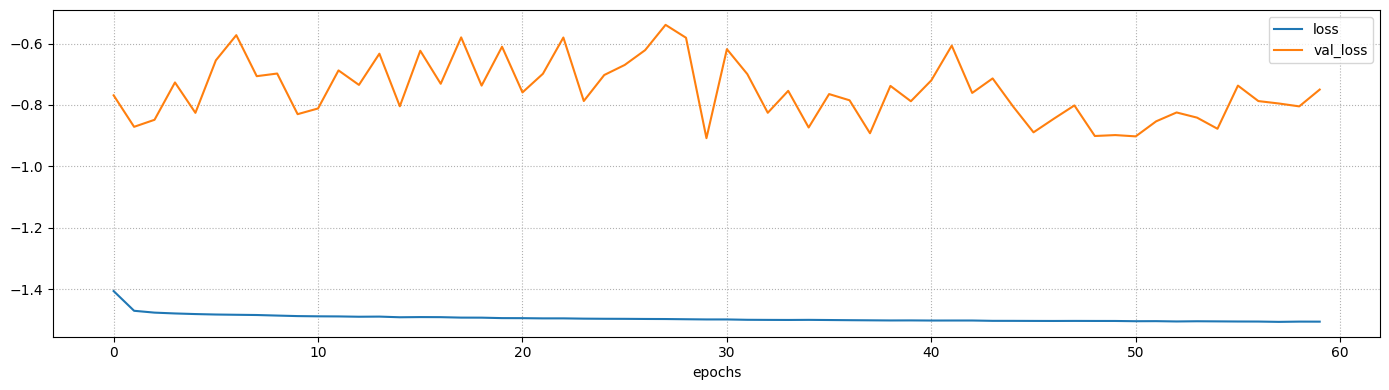

Final loss: -1.5057 (training), -0.7498 (validation)


In [34]:
X_train = inputs_train.values
X_val = inputs_val.values
X_test = inputs_test.values

print('Training the model with all morphoclimatic descriptors...')
full_model = build_nn_beta_model(input_shape=(X_train.shape[1],), hidden=[128,256]) #[256,128]
history = util.train_nn_model(full_model, X_train, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val, y_val))
util.plot_training_history(history, figsize=(14, 4))

* PCA-model

Training the model with the PCA of the morphoclimatic descriptors...
Epoch 1/90
409/409 [==============================] - 4s 7ms/step - loss: -1.3671 - val_loss: -0.7641
Epoch 2/90
409/409 [==============================] - 3s 7ms/step - loss: -1.4654 - val_loss: -0.7851
Epoch 3/90
409/409 [==============================] - 2s 5ms/step - loss: -1.4727 - val_loss: -1.0194
Epoch 4/90
409/409 [==============================] - 2s 5ms/step - loss: -1.4755 - val_loss: -0.9727
Epoch 5/90
409/409 [==============================] - 2s 5ms/step - loss: -1.4770 - val_loss: -0.9539
Epoch 6/90
409/409 [==============================] - 2s 5ms/step - loss: -1.4779 - val_loss: -0.9955
Epoch 7/90
409/409 [==============================] - 3s 6ms/step - loss: -1.4786 - val_loss: -0.9906
Epoch 8/90
409/409 [==============================] - 2s 5ms/step - loss: -1.4802 - val_loss: -0.9515
Epoch 9/90
409/409 [==============================] - 2s 6ms/step - loss: -1.4802 - val_loss: -0.9322
Epoch 10/90
4

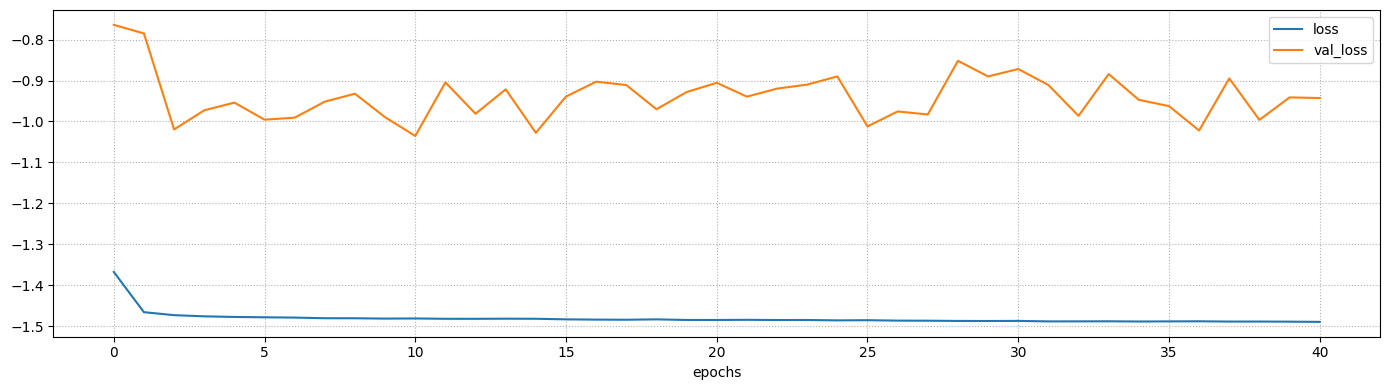

Final loss: -1.4890 (training), -0.9427 (validation)


In [35]:
X_train_pca = inputs_train_pca.values
X_val_pca = inputs_val_pca.values
X_test_pca = inputs_test_pca.values

print('Training the model with the PCA of the morphoclimatic descriptors...')
pca_model = build_nn_beta_model(input_shape=(X_train_pca.shape[1],), hidden=[128,256]) #[256,128]
history = util.train_nn_model(pca_model, X_train_pca, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_pca, y_val))
util.plot_training_history(history, figsize=(14, 4))

# Evaluation

In [36]:
results = pd.DataFrame()

* MAP-model evaluation

Evaluating the Map-model on Train set...


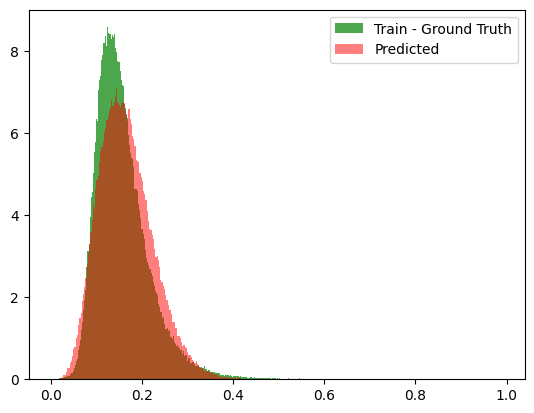

In [37]:
model_name = 'Map-model'

split = 'Train'
results[0] = util.evaluation(map_model, X_train_map, y_train, model_name, split)
dist_train_map = map_model(X_train_map)

Evaluating the Map-model on Val set...


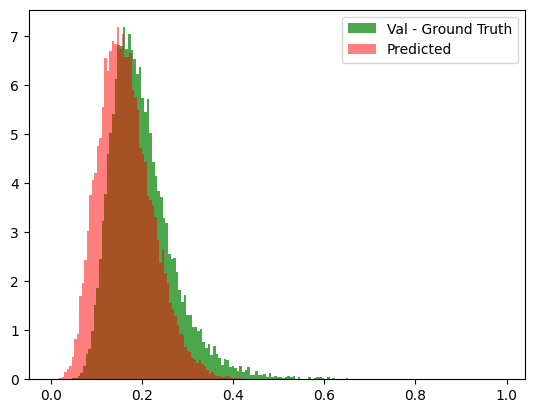

In [38]:
split = 'Val'
results[1] = util.evaluation(map_model, X_val_map, y_val, model_name, split)
dist_val_map = map_model(X_val_map)

Evaluating the Map-model on Test set...


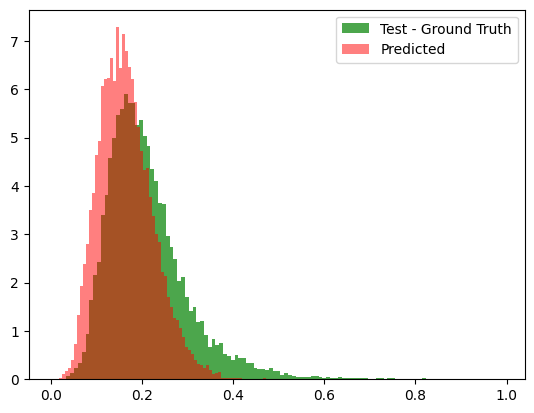

In [39]:
split = 'Test'
results[2] = util.evaluation(map_model, X_test_map, y_test, model_name, split)
dist_test_map = map_model(X_test_map)

* Full-model evaluation

Evaluating the Full-model on Train set...


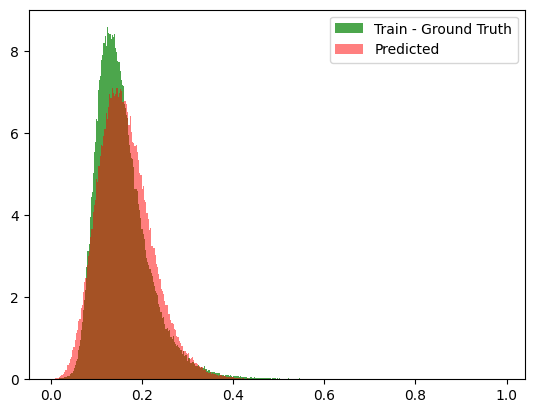

In [40]:
model_name = 'Full-model'

split = 'Train'
results[3] = util.evaluation(full_model, X_train, y_train, model_name, split)
dist_train_full = full_model(X_train)

Evaluating the Full-model on Val set...


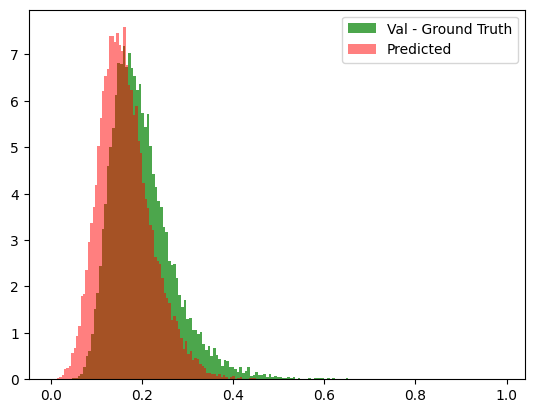

In [41]:
split = 'Val'
results[4] = util.evaluation(full_model, X_val, y_val, model_name, split)
dist_val_full = full_model(X_val)

Evaluating the Full-model on Test set...


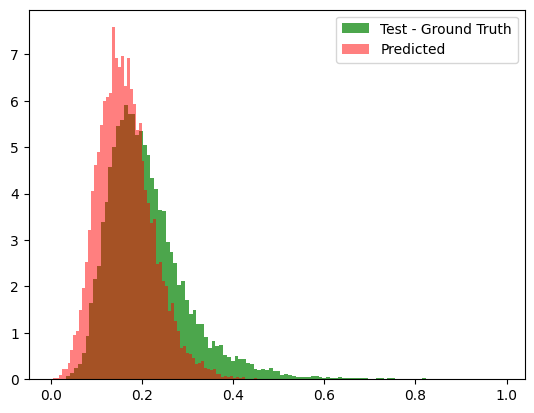

In [42]:
split = 'Test'
results[5] = util.evaluation(full_model, X_test, y_test, model_name, split)
dist_test_full = full_model(X_test)

* PCA-model evaluation

Evaluating the Pca-model on Train set...


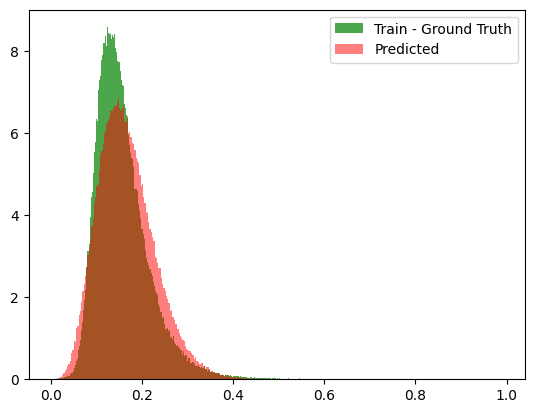

In [43]:
model_name = 'Pca-model'

split = 'Train'
results[6] = util.evaluation(pca_model, X_train_pca, y_train, model_name, split)
dist_train_pca = pca_model(X_train_pca)

Evaluating the Pca-model on Val set...


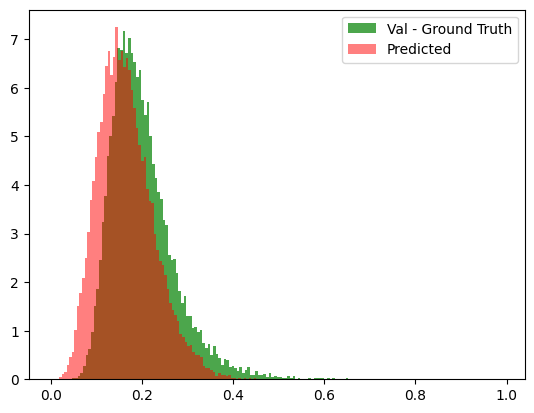

In [44]:
split = 'Val'
results[7] = util.evaluation(pca_model, X_val_pca, y_val, model_name, split)
dist_val_pca = pca_model(X_val_pca)

Evaluating the Pca-model on Test set...


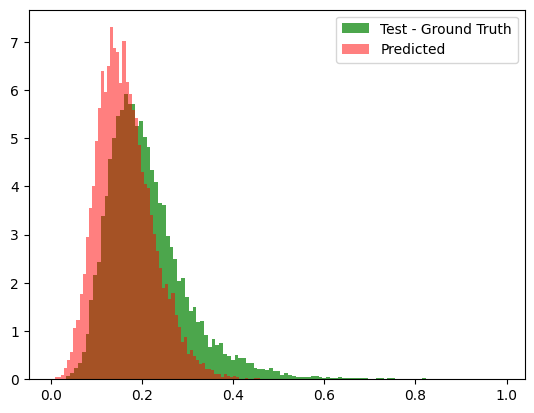

In [45]:
split = 'Test'
results[8] = util.evaluation(pca_model, X_test_pca, y_test, model_name, split)
dist_test_pca = pca_model(X_test_pca)

In [46]:
results = results.T
results.columns=['Split', 'MAE', 'KS statistics']
display(results)

,Split,MAE,KS statistics
0,Train,0.065634,0.090293
1,Val,0.075985,0.201136
2,Test,0.087332,0.218795
3,Train,0.065081,0.078803
4,Val,0.076398,0.213423
5,Test,0.086647,0.22075
6,Train,0.067116,0.093887
7,Val,0.077269,0.2055
8,Test,0.089006,0.228497


### Distribution mean - confidence interval 

In [47]:
confidence = 0.99

Evaluation of MAP-model based on confidence intervals..


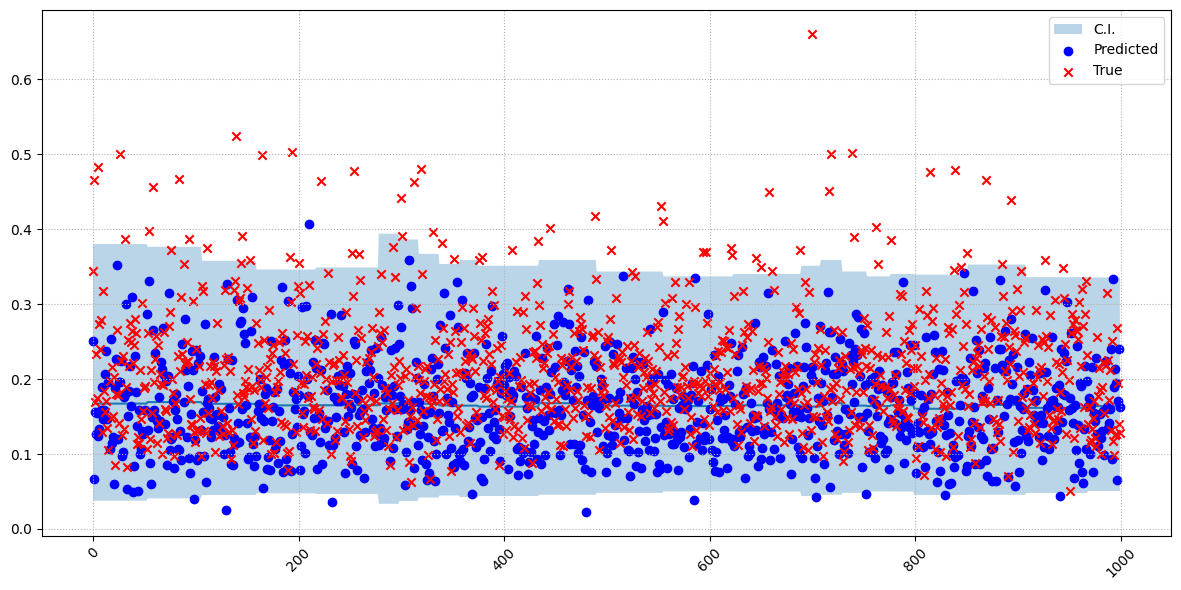

Percentage of values inside the 99% confidence interval: 92.41%


In [48]:
print('Evaluation of MAP-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_map, y_test, dist_test_map, confidence, distribution = 'beta', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of Full-model based on confidence intervals..


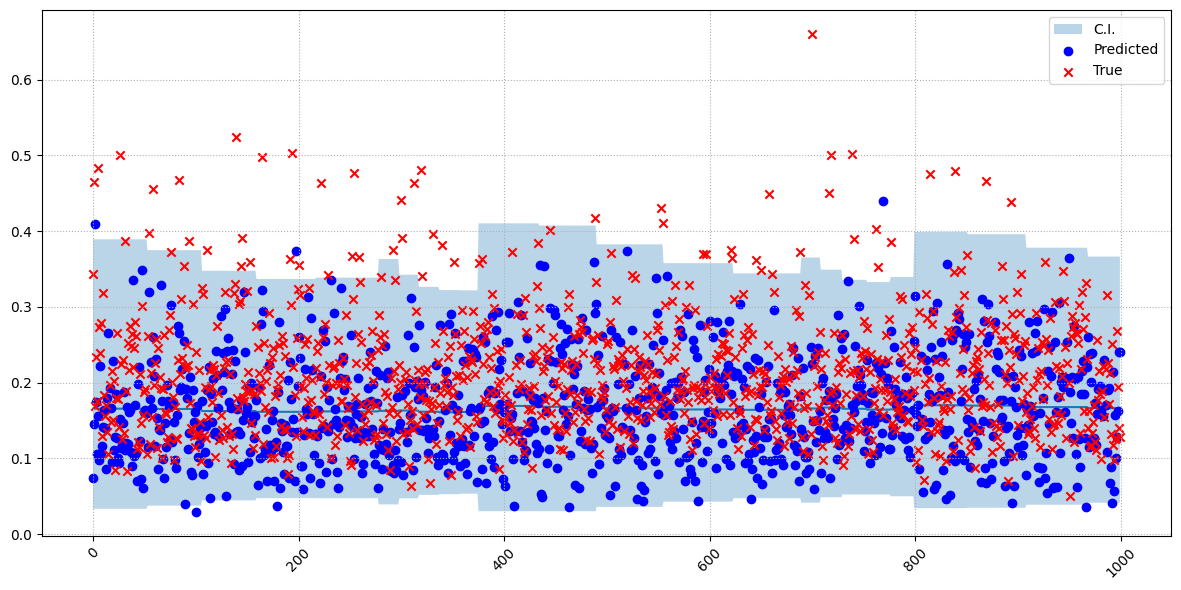

Percentage of values inside the 99% confidence interval: 91.46%


In [49]:
print('Evaluation of Full-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test, y_test, dist_test_full, confidence, distribution = 'beta', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of PCA-model based on confidence intervals..


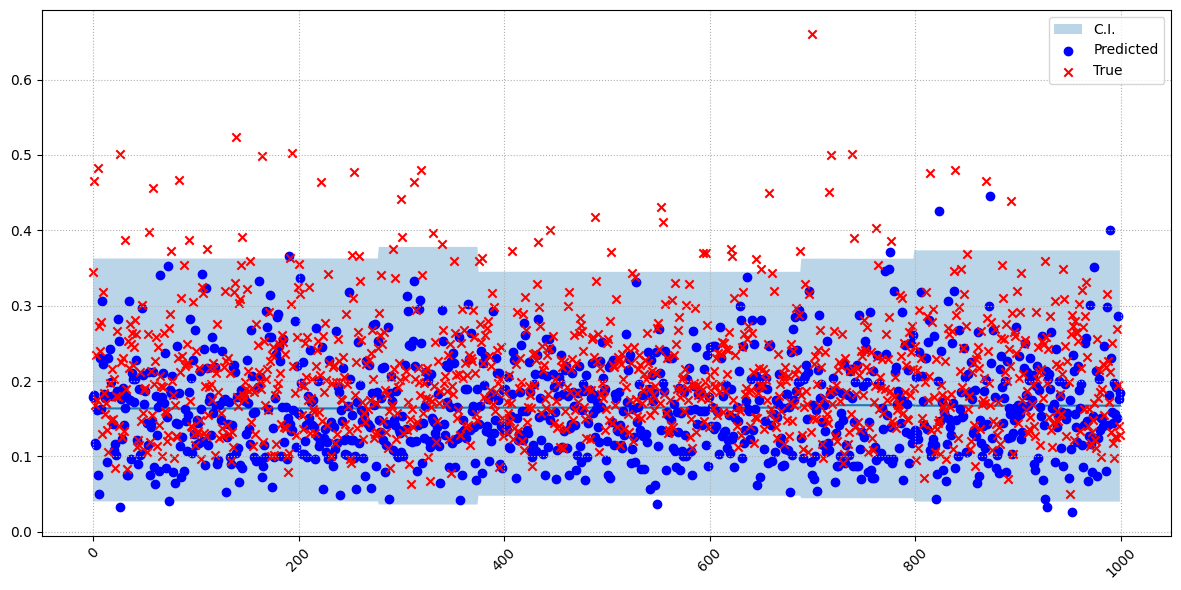

Percentage of values inside the 99% confidence interval: 91.70%


In [50]:
print('Evaluation of PCA-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_pca, y_test, dist_test_pca, confidence, distribution = 'beta', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

# Parameters

* Metrics on parameters from MAP-model

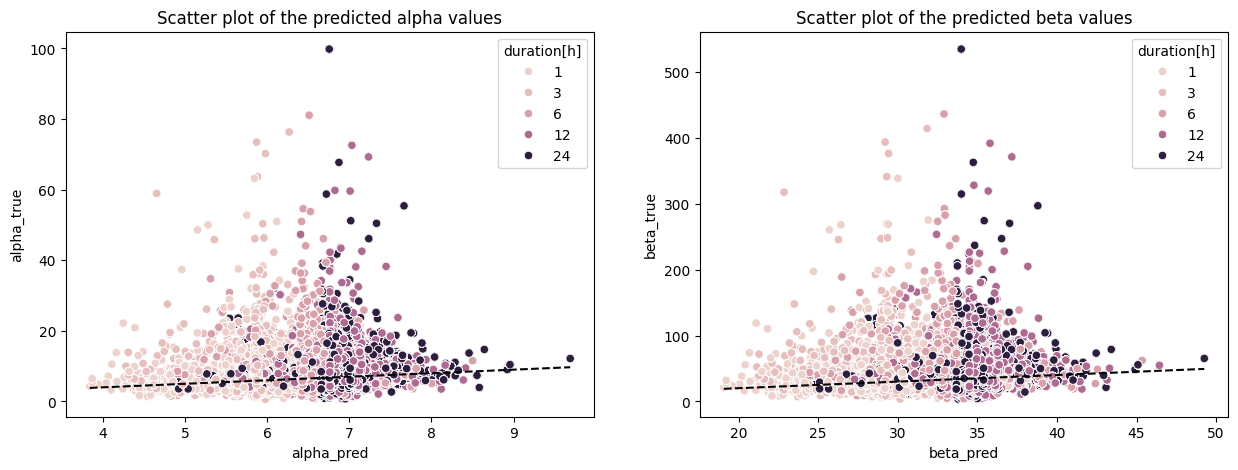

In [51]:
_ = util.parameters_metrics(dist_train_map, parameters_train, distribution_name = 'beta', calculate_metrics = False)

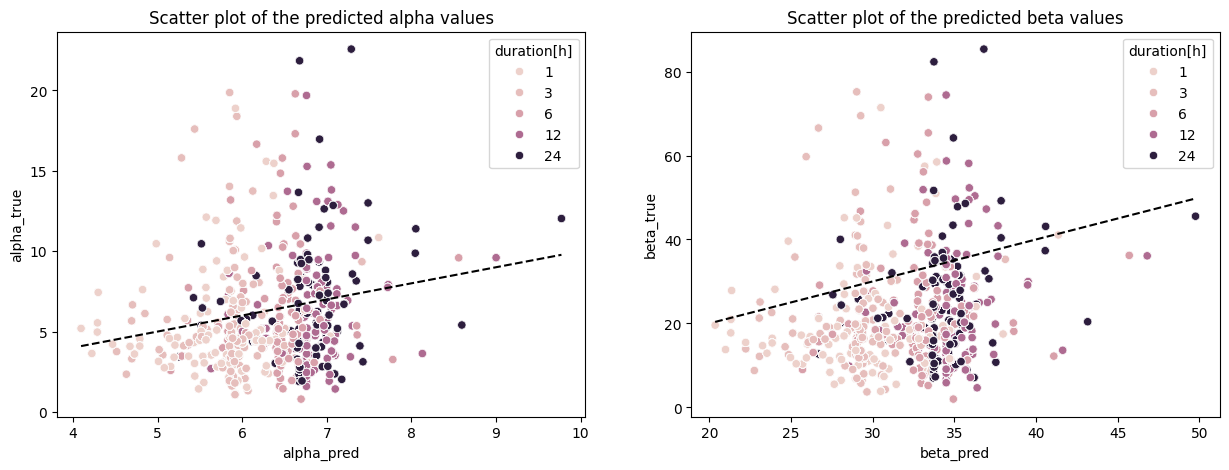

In [52]:
metrics_alpha_map, metrics_beta_map = util.parameters_metrics(dist_test_map, parameters_test, distribution_name='beta', indexes=durations_indexes_test, remove_outliers = False)

In [53]:
print('===============ALPHA PARAMETER===============')
metrics_alpha_map

===============ALPHA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.324820,-0.381390,-0.330006,-0.353676,-0.326289,-0.238784
rmse,7.864143,6.788446,7.763903,9.100410,8.205324,7.421957
pcc,0.223360,0.158391,0.015158,0.074501,0.109177,0.178280


In [54]:
print('===============BETA PARAMETER===============')
metrics_beta_map

===============BETA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.829846,-0.934513,-0.807962,-0.905347,-0.827341,-0.684336
rmse,217.913894,208.014253,193.197308,242.036191,242.785341,202.688133
pcc,0.220687,0.182503,0.010365,0.050490,0.110174,0.184232


* Metrics on parameters from Full-model

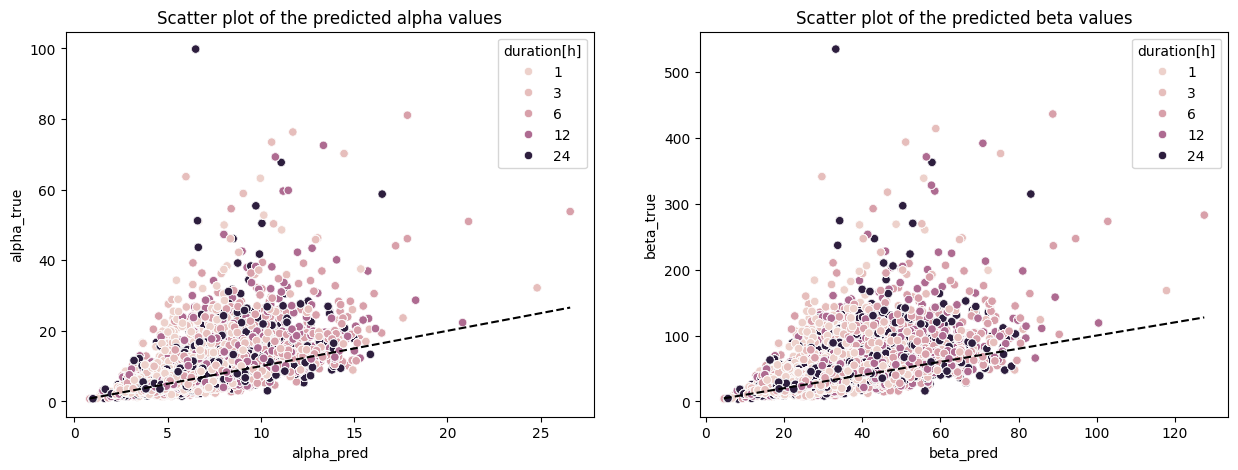

In [55]:
_ = util.parameters_metrics(dist_train_full, parameters_train, distribution_name = 'beta', calculate_metrics = False)

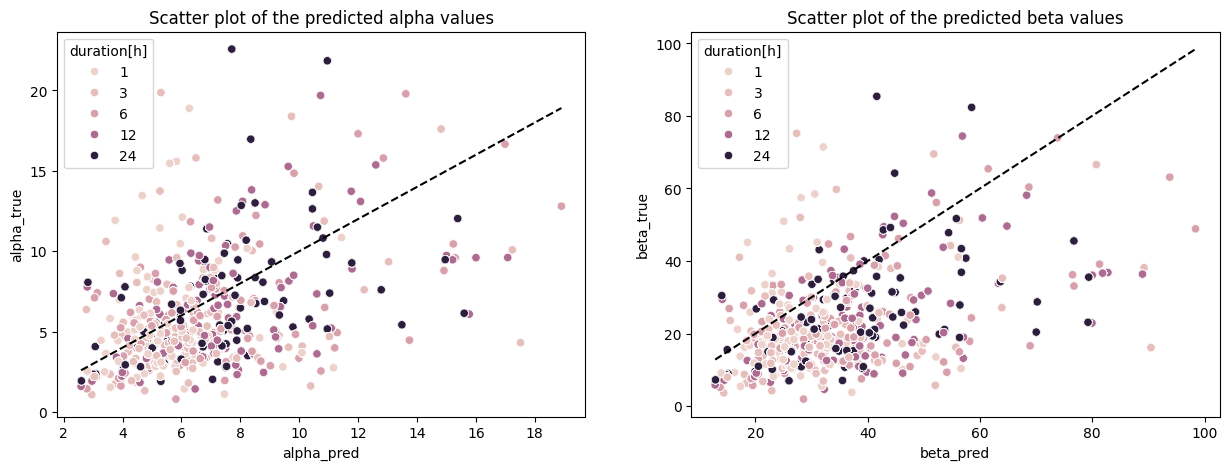

In [56]:
metrics_alpha_full, metrics_beta_full = util.parameters_metrics(dist_test_full, parameters_test, distribution_name='beta', indexes=durations_indexes_test, remove_outliers = False)

In [57]:
print('===============ALPHA PARAMETER===============')
metrics_alpha_full

===============ALPHA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.368907,-0.341392,-0.378414,-0.443716,-0.385436,-0.296974
rmse,10.089026,8.664685,9.744455,11.202762,11.090460,9.665287
pcc,0.394771,0.070405,0.306932,0.436939,0.404431,0.413936


In [58]:
print('===============BETA PARAMETER===============')
metrics_beta_full

===============BETA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.899463,-0.860392,-0.906324,-1.025915,-0.919738,-0.787302
rmse,368.909010,243.849495,321.521531,428.871744,445.267816,395.674968
pcc,0.412324,0.073263,0.314073,0.460921,0.429992,0.426412


* Metrics on parameters from PCA-model

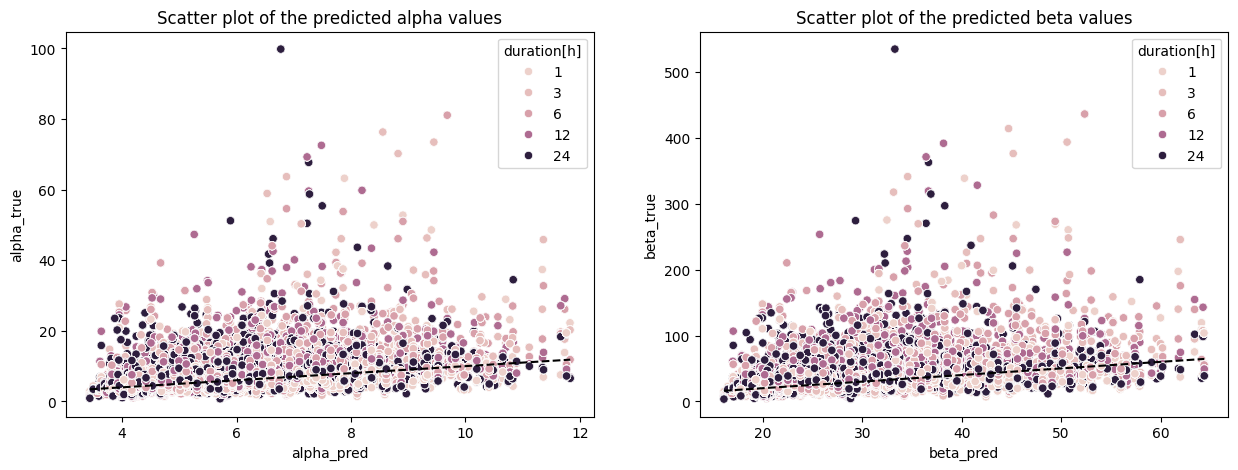

In [59]:
_ = util.parameters_metrics(dist_train_pca, parameters_train, distribution_name = 'beta', calculate_metrics = False)

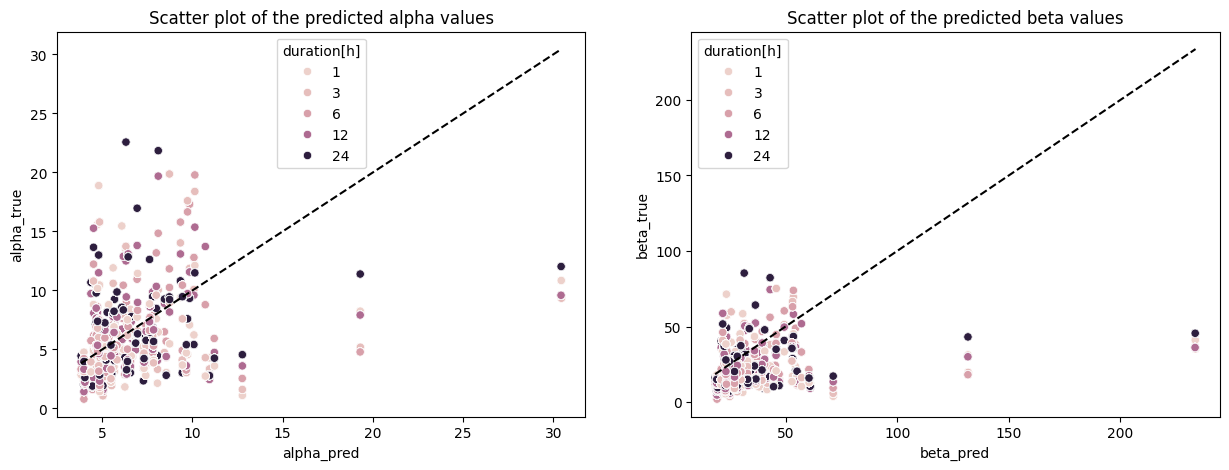

In [60]:
metrics_alpha_pca, metrics_beta_pca = util.parameters_metrics(dist_test_pca, parameters_test, distribution_name='beta', indexes=durations_indexes_test, remove_outliers = False)

In [61]:
print('===============ALPHA PARAMETER===============')
metrics_alpha_pca

===============ALPHA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.315884,-0.549124,-0.411381,-0.281067,-0.204754,-0.154372
rmse,12.135236,13.768942,11.943671,11.499442,11.697888,11.858641
pcc,0.241152,0.177542,0.290924,0.314366,0.234583,0.206184


In [62]:
print('===============BETA PARAMETER===============')
metrics_beta_pca

===============BETA PARAMETER===============


,global,1,3,6,12,24
biasr,-0.843651,-1.181645,-0.985363,-0.803841,-0.676902,-0.601843
rmse,560.277673,656.464913,603.312419,538.478435,512.268858,499.515184
pcc,0.222694,0.195882,0.255193,0.269820,0.207796,0.208747


### Comparison between two samples extracted from "true" and predicted distribution of the same place 

True alpha :  3.5850961360087763 Predicted  alpha : 4.21668
True beta :  19.013652302300454 Predicted  beta : 21.597338


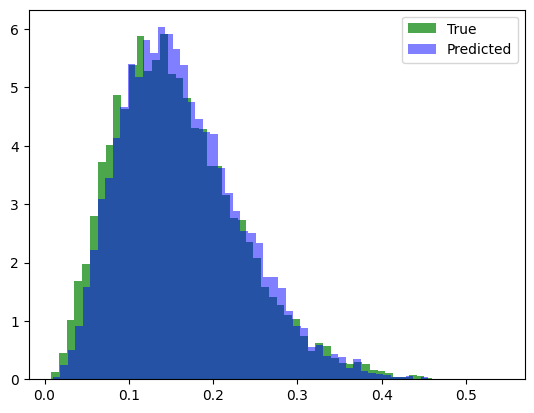

In [63]:
util.compare_samples(dist_train_full, "beta", parameters_train, index=20)

## Error Analysis


#### Beta Distribution

In [66]:
metrics_name = ['biasr', 'rmse', 'pcc']
models_name = ['map', 'full', 'pca']
models_metrics = [ metrics_alpha_map, metrics_alpha_full, metrics_alpha_pca]

In [68]:
alpha_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
alpha_metrics

,biasr_map,biasr_full,biasr_pca,rmse_map,rmse_full,rmse_pca,pcc_map,pcc_full,pcc_pca
global,-0.324820,-0.368907,-0.315884,7.864143,10.089026,12.135236,0.223360,0.394771,0.241152
1,-0.381390,-0.341392,-0.549124,6.788446,8.664685,13.768942,0.158391,0.070405,0.177542
3,-0.330006,-0.378414,-0.411381,7.763903,9.744455,11.943671,0.015158,0.306932,0.290924
6,-0.353676,-0.443716,-0.281067,9.100410,11.202762,11.499442,0.074501,0.436939,0.314366
12,-0.326289,-0.385436,-0.204754,8.205324,11.090460,11.697888,0.109177,0.404431,0.234583
24,-0.238784,-0.296974,-0.154372,7.421957,9.665287,11.858641,0.178280,0.413936,0.206184


In [69]:
models_metrics = [ metrics_beta_map, metrics_beta_full, metrics_beta_pca]
beta_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
beta_metrics

,biasr_map,biasr_full,biasr_pca,rmse_map,rmse_full,rmse_pca,pcc_map,pcc_full,pcc_pca
global,-0.829846,-0.899463,-0.843651,217.913894,368.909010,560.277673,0.220687,0.412324,0.222694
1,-0.934513,-0.860392,-1.181645,208.014253,243.849495,656.464913,0.182503,0.073263,0.195882
3,-0.807962,-0.906324,-0.985363,193.197308,321.521531,603.312419,0.010365,0.314073,0.255193
6,-0.905347,-1.025915,-0.803841,242.036191,428.871744,538.478435,0.050490,0.460921,0.269820
12,-0.827341,-0.919738,-0.676902,242.785341,445.267816,512.268858,0.110174,0.429992,0.207796
24,-0.684336,-0.787302,-0.601843,202.688133,395.674968,499.515184,0.184232,0.426412,0.208747


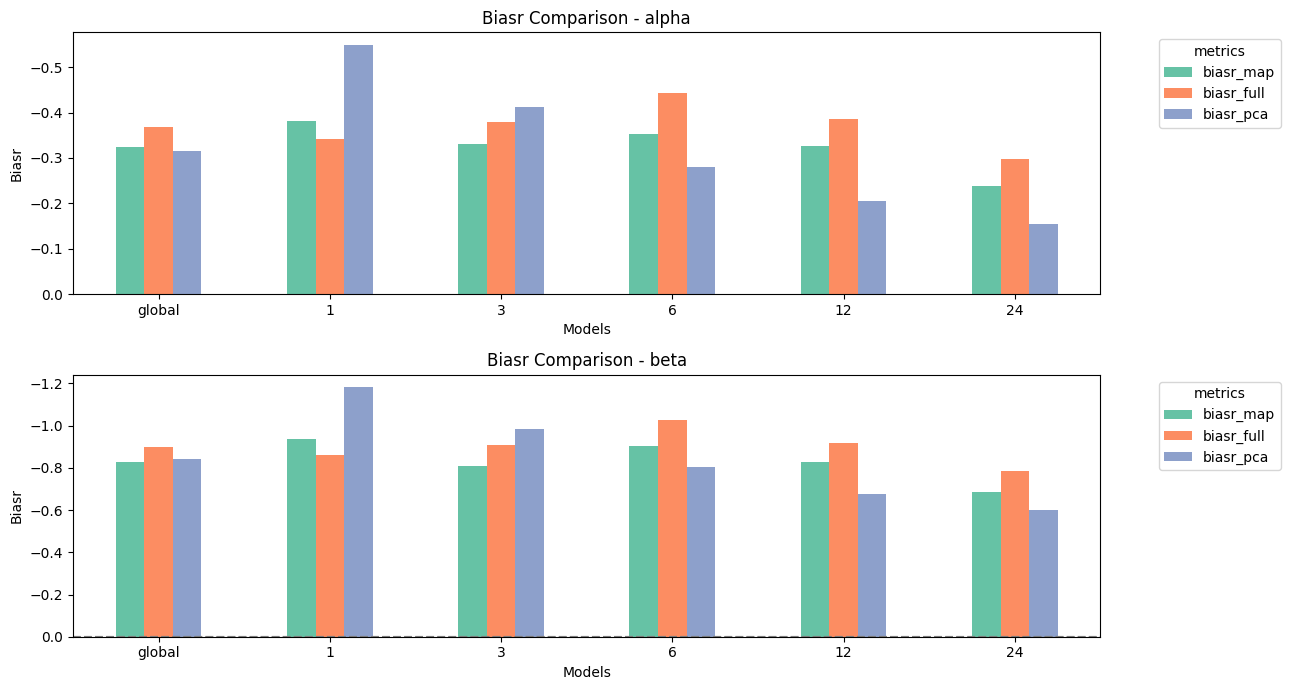

In [86]:
util.get_comparison_plot(alpha_metrics.iloc[:,0:3], beta_metrics.iloc[:,0:3], 'Biasr','beta', 'Set2')

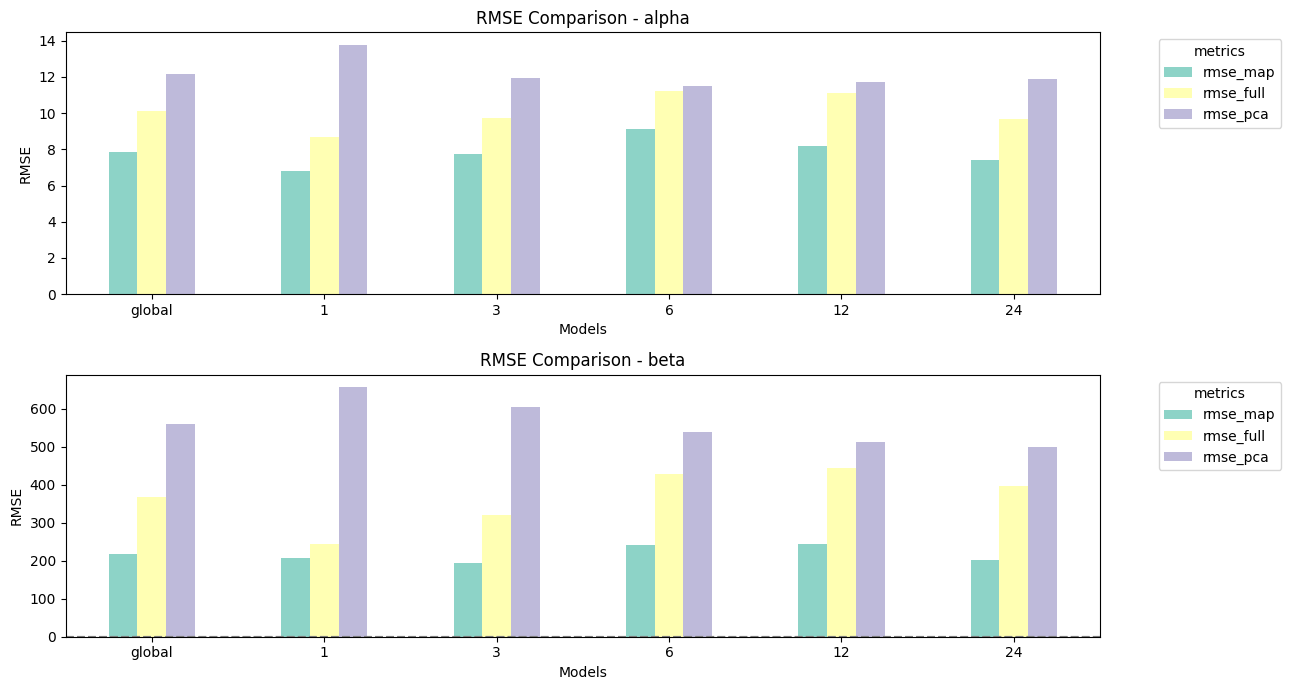

In [87]:
util.get_comparison_plot(alpha_metrics.iloc[:,3:6], beta_metrics.iloc[:,3:6], 'RMSE', 'beta','Set3')

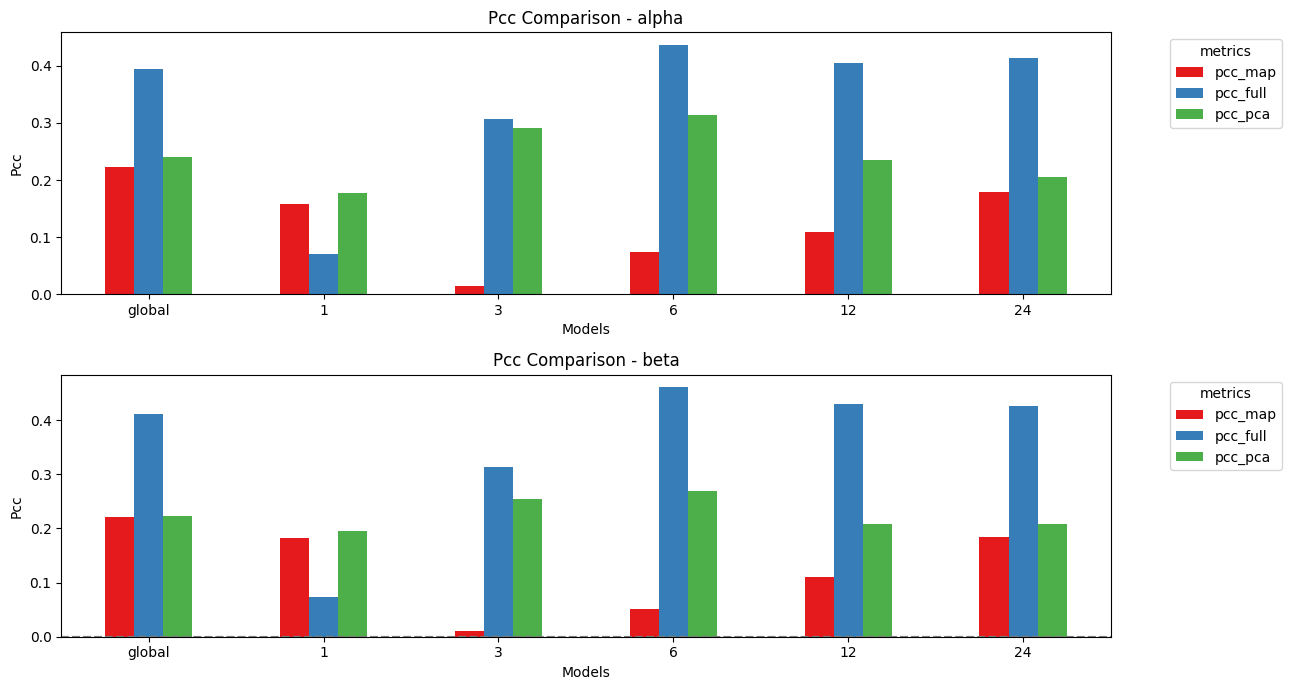

In [88]:
util.get_comparison_plot(alpha_metrics.iloc[:,6:9], beta_metrics.iloc[:,6:9], 'Pcc','beta', 'Set1')

The metrics used to evaluate the predictions on alpha and beta are: RMSE (Root Mean Squared Error), Relative Bias, and PCC (Pearson Correlation Coefficient).
- RMSE: It measures the difference between the values predicted by a model and the observed values, a lower value indicates better model accuracy. 
This is likely due to the wide variability in parameter values, making the model more prone to incorrectly predicting high values of alpha and beta.

- RBIAS:
If it is close to zero indicates that the model has a good tendency to predict values correctly, when it is positive the model tend to overestimate, while a negative relative bias indicates a tendency to underestimate the parameter.
 The Beta models tend to understimate the value of alpha and beta, in particular when considering the duration 1.

- PCC: It is a measure of the linear relationship between two variables.
It can range from -1 to 1. A value of 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no linear correlation.



Observing the graph, one of the first notable things is that the models show specular performance in predicting alpha and in predicting beta. Global metrics do not always reflect what is obtained considering the individual durations in which the use of one model rather than the other can lead to different results.

( Sta cosa non ha nessun senso poi indago )
Comparing the different models, the best-performing one appears to be the MAP model, while the least performing one is the PCA model.

#### Gumbel Distribution

In [91]:
loc_metrics = pd.read_pickle('results/loc_metrics.pkl')
scale_metrics = pd.read_pickle('results/scale_metrics.pkl')

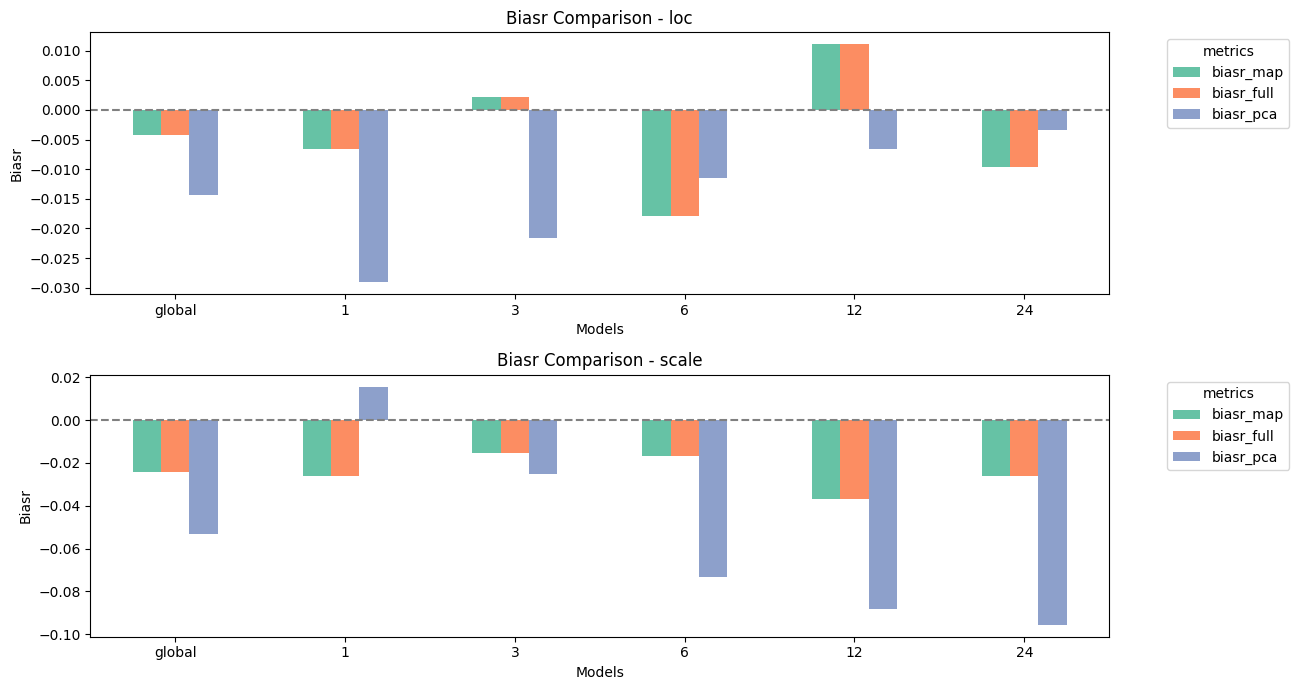

In [92]:
util.get_comparison_plot(loc_metrics.iloc[:,0:3], scale_metrics.iloc[:,0:3], 'Biasr','gumbel','Set2')

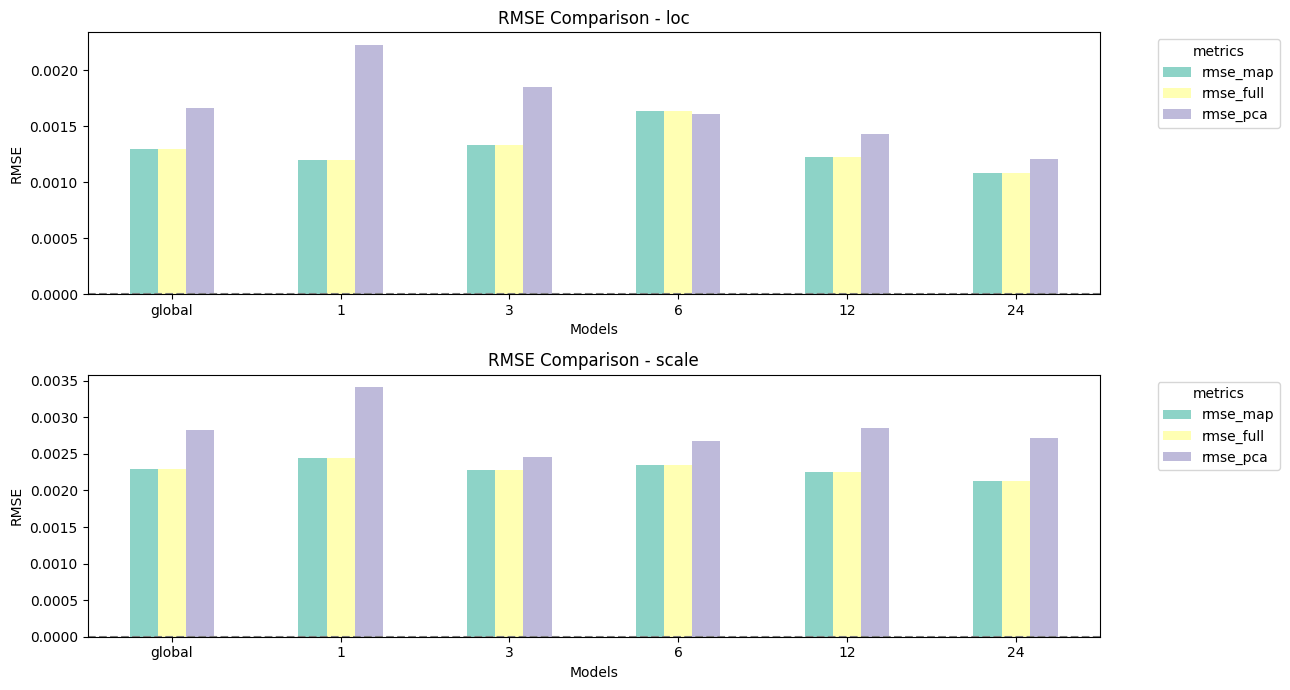

In [96]:
util.get_comparison_plot(loc_metrics.iloc[:,3:6], scale_metrics.iloc[:,3:6], 'RMSE', 'gumbel', 'Set3')

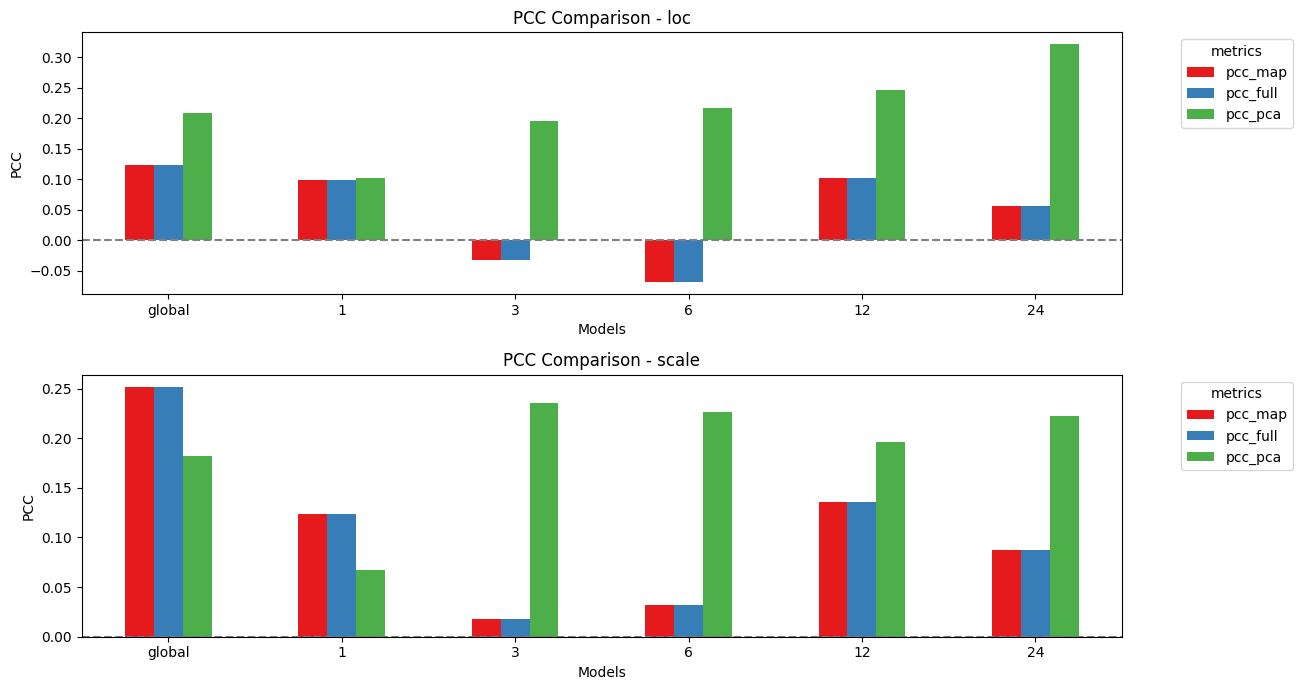

In [97]:
util.get_comparison_plot(loc_metrics.iloc[:,6:9], scale_metrics.iloc[:, 6:9], 'PCC', 'gumbel', 'Set1')

The results of the Gumbel are less symmetrical than those obtained with the Beta distribution. Observing the various metrics, the models therefore obtain different results for location and scale. In particular, the MAP model and the full model show similar results, generally better than those obtained through PCA

The metrics suggest that:

- All three models are capable of estimating the parameters fairly accurately with minimal errors (RMSE), often slightly underestimating them (RBias).
- The data does not exhibit a strong linear relationship (PCC)

#### Distributions Comparison

Since the results are all around the same order of magnitude, to compare the distributions we consider the 'global' values 

In [104]:
biasr_comparison = pd.DataFrame()

In [105]:
biasr_comparison["loc"] = loc_metrics.iloc[0,0:3].values
biasr_comparison["scale"] = scale_metrics.iloc[0,0:3].values
biasr_comparison["alpha"] = alpha_metrics.iloc[0,0:3].values
biasr_comparison["beta"] = beta_metrics.iloc[0,0:3].values

In [108]:
biasr_comparison.index = ['map', 'full', 'pca']
biasr_comparison

,loc,scale,alpha,beta
map,-0.004181,-0.024254,-0.324820,-0.829846
full,-0.004181,-0.024254,-0.368907,-0.899463
pca,-0.014429,-0.053222,-0.315884,-0.843651


In [117]:
def plot_biasr_comparison(df, title):
  fig, ax = plt.subplots(figsize=(18, 7))
  colors = sns.color_palette("Set2", 4)
  df.plot(kind='bar', ax=ax, rot=0, color=colors)

  plt.title('Scores Comparison'+" - " + title)
  plt.xlabel('Models')
  plt.ylabel('F1 Score')
  plt.legend(title='metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
  ax.invert_yaxis()
  plt.tight_layout()

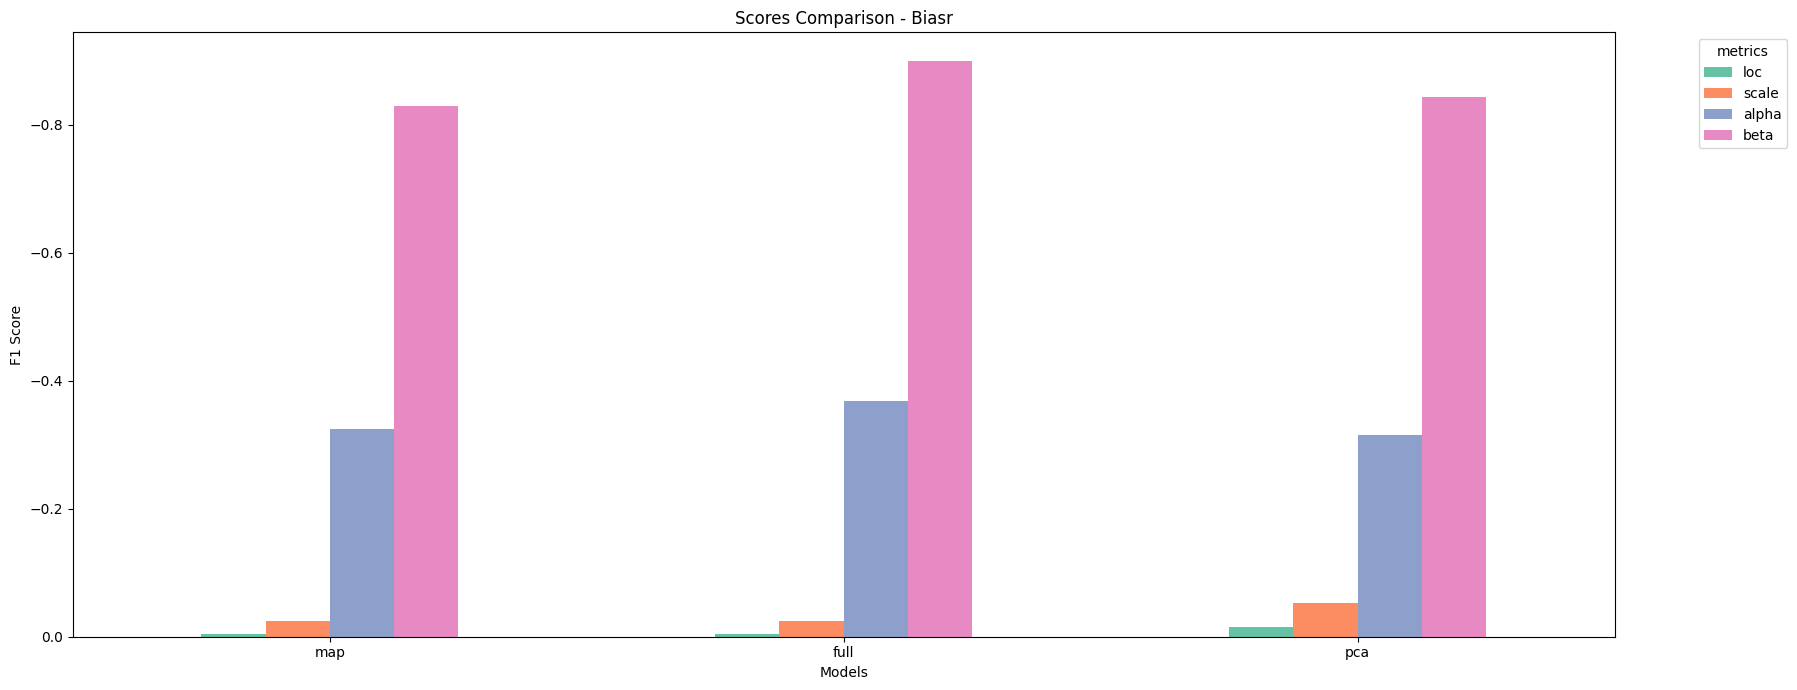

In [118]:
plot_biasr_comparison(biasr_comparison, 'Biasr')

For a more faithful comparison, we focused on the relative bias metrics as it is a dimensionless and independent of the magnitude of the values.
Observing the graph, it is evident that the estimates made by the Gumbel distribution are much more accurate than those of the Beta distribution,
However, it should be considered that we are considering the estimation made by the scipy fitter as the 'true' value for the parameter, and  there is no certainty that they are actually accurate. Greater confidence would be achieved if all measurements had an higher number of observations.